In [6]:
# keyword/ topic extraction

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords

# load cleaned data
df_chats = pd.read_csv('cleaned_data/chats_clean.csv')
df_chats.head()

,id,client_id,question,answer,created_at,updated_at,bot_id,type,image_url,audio_url,has_image,has_audio
0,1,1,do you recommend traveling to beirut right now?,Traveling to Beirut can be a wonderful experie...,2024-08-19 14:44:14,2024-08-19 14:44:14,0,text,NaN,NaN,0,0
1,2,1,when is the next flight going to italy?,The next flight from Beirut Airport to Italy i...,2024-08-19 14:45:19,2024-08-19 14:45:19,0,text,NaN,NaN,0,0
2,3,1,"hello, tell me more about yourself",Hello! I'm here to assist you with your travel...,2024-08-19 14:52:22,2024-08-19 14:52:22,0,text,NaN,NaN,0,0
3,4,1,hello tell me more about yourself,"Hello! I am your traveler assistant, here to h...",2024-08-19 14:53:10,2024-08-19 14:53:10,0,text,NaN,NaN,0,0
4,5,1,who developed you,I was developed by Ibrahim Fleifel at Xpertbot...,2024-08-19 14:53:28,2024-08-19 14:53:28,0,text,NaN,NaN,0,0


In [7]:
# 1. basic preprocessing

questions = df_chats['question'].dropna().astype(str).str.lower()

# remove any non-alphabetic characters or special characters
questions = questions.apply(lambda x: re.sub(r'[^a-z\s]', '', x))

#tokenize and remove stopwords

stop_words = set(stopwords.words('english'))
tokens = [word for q in questions for word in q.split() if word not in stop_words]

In [8]:
# ---- 2. Word frequency ----
word_counts = Counter(tokens)
top_words = word_counts.most_common(20)

# Convert to DataFrame for plotting
df_top_words = pd.DataFrame(top_words, columns=['word', 'count'])
top_words

[('image', 1189),
 ('de', 1178),
 ('la', 800),
 ('analysis', 673),
 ('et', 649),
 ('hi', 601),
 ('les', 592),
 ('result', 583),
 ('des', 555),
 ('hello', 527),
 ('le', 510),
 ('en', 432),
 ('question', 333),
 ('want', 319),
 ('un', 305),
 ('une', 302),
 ('give', 302),
 ('lebanon', 294),
 ('text', 272),
 ('pour', 271)]

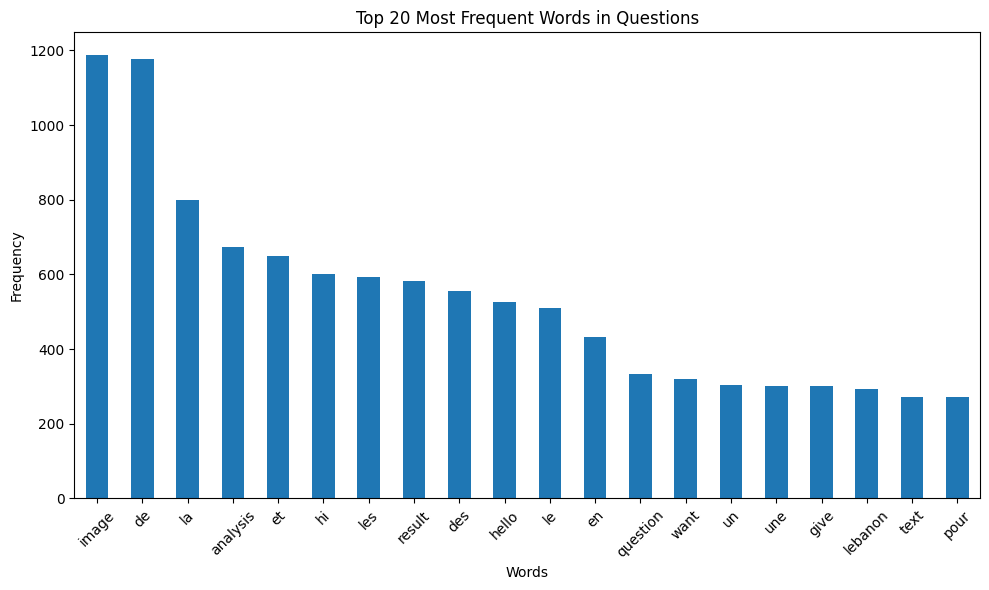

In [9]:
#plot top 20 words
df_top_words.plot(kind='bar', x='word', y='count', legend=False, figsize=(10, 6))
plt.title('Top 20 Most Frequent Words in Questions')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

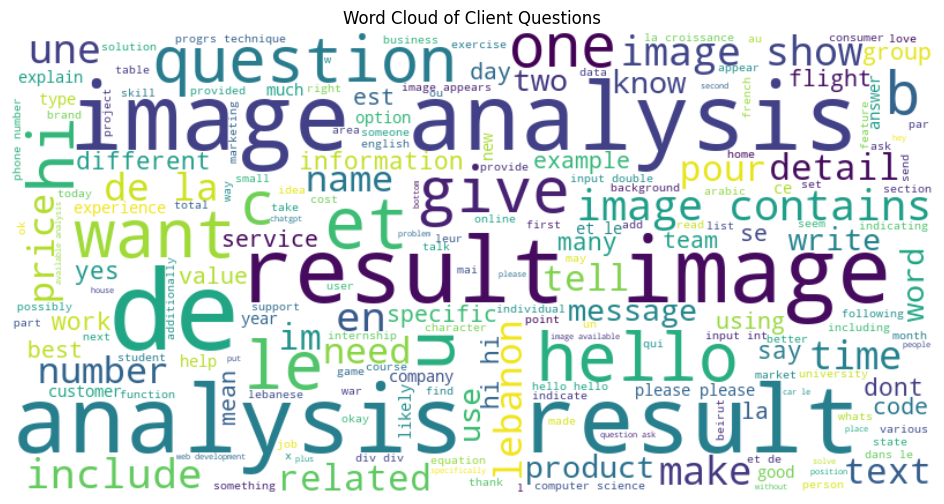

In [10]:
# ---- 4. Word Cloud ----
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(tokens))

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Client Questions")
plt.show()

In [11]:
import numpy as np

# Define positive & negative satisfaction keywords
positive_keywords = ["thanks", "thank you", "great", "perfect", "good", "awesome", "helpful"]
negative_keywords = ["bad", "not working", "useless", "terrible", "worst", "error", "problem"]

def get_satisfaction_score(text):
    text = str(text).lower()
    if any(word in text for word in positive_keywords):
        return 1   # positive satisfaction
    elif any(word in text for word in negative_keywords):
        return -1  # negative satisfaction
    else:
        return 0   # neutral / unknown

# Apply to the 'answer' column
df_chats["satisfaction"] = df_chats["answer"].apply(get_satisfaction_score)

# Aggregate by overall
satisfaction_counts = df_chats["satisfaction"].value_counts(normalize=True) * 100

print("Satisfaction Distribution (%):")
print(satisfaction_counts)

# Aggregate by client
satisfaction_by_client = df_chats.groupby("client_id")["satisfaction"].mean().reset_index()
satisfaction_by_client.rename(columns={"satisfaction": "avg_satisfaction"}, inplace=True)

print("\nSample Client Satisfaction:")
print(satisfaction_by_client.head())


Satisfaction Distribution (%):
satisfaction
 0    84.565829
 1    11.351057
-1     4.083114
Name: proportion, dtype: float64

Sample Client Satisfaction:
   client_id  avg_satisfaction
0          1          0.056738
1          2          0.100000
2          3          0.000000
3          4          0.000000
4          5          0.000000


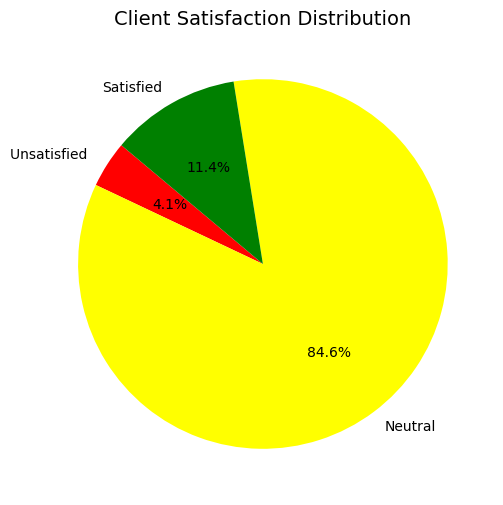

In [12]:
# pie chart of satisfaction distribution
satisfaction_dist = {
    -1: 4.08,
     0: 84.57,
     1: 11.35
}
labels = ['Unsatisfied ', 'Neutral', 'Satisfied']
sizes = [satisfaction_dist[-1], satisfaction_dist[0], satisfaction_dist[1]]
colors = ['red', 'yellow', 'green']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Client Satisfaction Distribution', fontsize=14)
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_19996\2448411320.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette=colors)


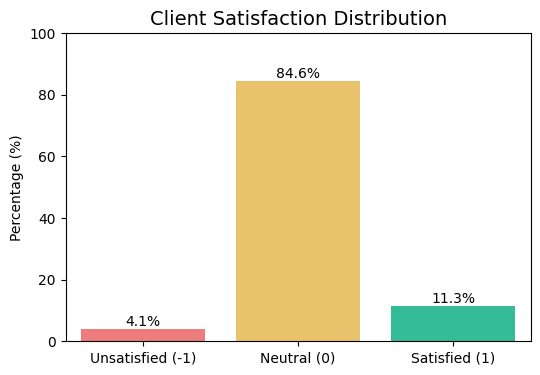

In [13]:
# Satisfaction distribution
import seaborn as sns
satisfaction_dist = {
    -1: 4.08,
     0: 84.57,
     1: 11.35
}

labels = ['Unsatisfied (-1)', 'Neutral (0)', 'Satisfied (1)']
values = [satisfaction_dist[-1], satisfaction_dist[0], satisfaction_dist[1]]
colors = ['#ff6b6b', '#feca57', '#1dd1a1']  # red, yellow, green

plt.figure(figsize=(6,4))
sns.barplot(x=labels, y=values, palette=colors)
plt.ylabel("Percentage (%)")
plt.title("Client Satisfaction Distribution", fontsize=14)
plt.ylim(0,100)
for i, v in enumerate(values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10)
plt.show()

In [14]:
df_chats.to_csv('cleaned_data/chats_with_satisfaction.csv', index=False)